In [75]:
# Import dependencies
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [76]:
# Load dataset
df = pd.read_csv(".\chapter_3\src\data\Electric_Production.csv")
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [77]:
# Extract data
data = df[['IPG2211A2N']].values
data[:5]

array([[72.5052],
       [70.672 ],
       [62.4502],
       [57.4714],
       [55.3151]])

In [78]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data)
data_norm[:5]

array([[0.23201741],
       [0.20727443],
       [0.09630353],
       [0.02910391],
       [0.        ]])

In [79]:
# Prepare data for training
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        a = data[i:(i + time_steps), 0]
        X.append(a)
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [80]:
TIME_STEPS = 60

X, y = create_dataset(data_norm, TIME_STEPS)
print("Length of data: ", len(data))
print("Length of X: ", len(X))
print("Shape of first element in X: ", X[0].shape if len(X) > 0 else "X is empty")
print("Length of y: ", len(y))

# Reshape X to fit LSTM input shape requirements (if X is not empty)
if len(X) > 0:
    X = X.reshape(X.shape[0], X.shape[1], 1)
    print("Shape of X after reshaping: ", X.shape)

print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

Length of data:  397
Length of X:  336
Shape of first element in X:  (60,)
Length of y:  336
Shape of X after reshaping:  (336, 60, 1)
Shape of X:  (336, 60, 1)
Shape of y:  (336,)


In [81]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, Layer, LayerNormalization, Dropout
from keras import Sequential
import tensorflow as tf

input_shape = (X.shape[1], X.shape[2])
inputs = Input(shape=input_shape)

# Embedding layer
x = Dense(128)(inputs)

class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)
        
    def attention(self, query, key, value):    
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)    
        
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        
        return output
    
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def call(self, inputs):
        attention_output = self.att(inputs)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [82]:
# Transformer block
for _ in range(4):
    x = TransformerBlock(embed_dim=128, num_heads=8, ff_dim=512)(x)
    
# Flatten layer
x = Flatten()(x)
outputs = Dense(1)(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=20, batch_size=32, verbose=2)

Epoch 1/20
11/11 - 7s - 616ms/step - loss: 21.6617
Epoch 2/20
11/11 - 0s - 44ms/step - loss: 1.7220
Epoch 3/20
11/11 - 1s - 48ms/step - loss: 0.7229
Epoch 4/20
11/11 - 0s - 42ms/step - loss: 0.4060
Epoch 5/20
11/11 - 0s - 43ms/step - loss: 0.2667
Epoch 6/20
11/11 - 0s - 45ms/step - loss: 0.1943
Epoch 7/20
11/11 - 0s - 43ms/step - loss: 0.1589
Epoch 8/20
11/11 - 0s - 43ms/step - loss: 0.1778
Epoch 9/20
11/11 - 0s - 41ms/step - loss: 0.1486
Epoch 10/20
11/11 - 0s - 44ms/step - loss: 0.1452
Epoch 11/20
11/11 - 1s - 56ms/step - loss: 0.1602
Epoch 12/20
11/11 - 1s - 49ms/step - loss: 0.1557
Epoch 13/20
11/11 - 1s - 47ms/step - loss: 0.1688
Epoch 14/20
11/11 - 1s - 46ms/step - loss: 0.1416
Epoch 15/20
11/11 - 0s - 45ms/step - loss: 0.1772
Epoch 16/20
11/11 - 0s - 44ms/step - loss: 0.1774
Epoch 17/20
11/11 - 0s - 44ms/step - loss: 0.1619
Epoch 18/20
11/11 - 0s - 43ms/step - loss: 0.1381
Epoch 19/20
11/11 - 0s - 45ms/step - loss: 0.1438
Epoch 20/20
11/11 - 0s - 45ms/step - loss: 0.1387


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
RMSE: 16.061252095985083


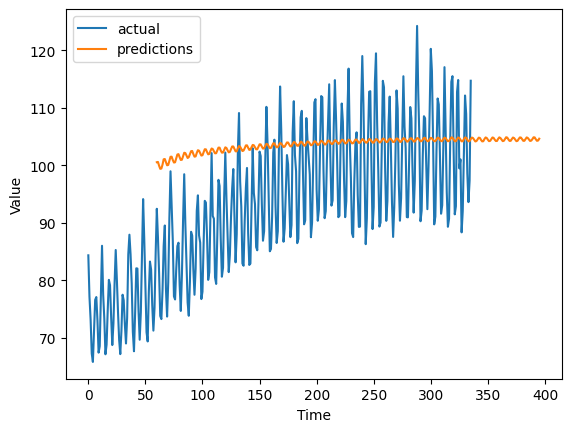

In [83]:
import matplotlib.pyplot as plt

preds = model.predict(X)

# Inverse transform the preds
preds_inv = scaler.inverse_transform(preds)

# Inverse transform the actuals
actuals_inv = scaler.inverse_transform(y.reshape(-1, 1))

# Calculate the RMSE
rmse = np.sqrt(np.mean((actuals_inv - preds_inv) ** 2))
print("RMSE:", rmse)

# Plot the results
plt.plot(actuals_inv, label="actual")
plt.plot(np.arange(TIME_STEPS, TIME_STEPS + len(preds_inv)), preds_inv, label="predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()